In [95]:
import os
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import patches
from scipy.stats import multivariate_normal
from scipy.special import digamma
import scipy.spatial as ss

from imp import reload

from info_measures.numpy import kolchinsky_tracey as kt
from info_measures.numpy import kraskov_stoegbauer_grassberger as ksg

%matplotlib inline

In [96]:
prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']
names = ['true', 'upper', 'lower', 'ek1', 'ek2']
cs = {n: c for n, c in zip(['true', 'upper', 'lower', 'ek1', 'ek2'], colors)}

# Entropy

In [108]:
dim = 3
mu = np.zeros(dim)
svar = np.diag(np.power(10., np.arange(dim) - (dim-1.)/2.))

In [109]:
e = np.asscalar(multivariate_normal(mu, svar).entropy())

# Scaling with data

In [110]:
n_repeat = 10
n = np.logspace(1, 3.5, 15, dtype=int)
eu = np.zeros((n.size, n_repeat))
el = np.zeros((n.size, n_repeat))
ek1 = np.zeros((n.size, n_repeat))

In [111]:
reload(kt)
reload(ksg)
for ii, ns in enumerate(n):
    for jj in range(n_repeat):
        x = np.random.multivariate_normal(mu, svar, size=ns)
        kt_estimator = kt.Entropy(x)
        ksg_estimator = ksg.Entropy(x)
        eu[ii, jj] = kt_estimator.entropy(lower=False)
        el[ii, jj] = kt_estimator.entropy(lower=True)
        ek1[ii, jj] = ksg_estimator.entropy()

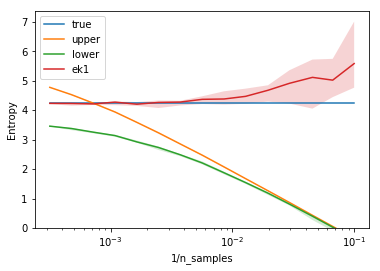

In [112]:
f = plt.figure()
true = np.ones((n.size, n_repeat)) * e
for x, name in zip([true, eu, el, ek1], names):
    plt.plot(1./n, np.median(x, axis=-1), label=name, c=cs[name])
    if name != 'true':
        plt.fill_between(1./n, np.percentile(x, 2.5, axis=-1), np.percentile(x, 97.5, axis=-1),
                         facecolor=cs[name], alpha=.2)

plt.ylim(0, None)
plt.xscale('log')
plt.ylabel('Entropy')
plt.xlabel('1/n_samples')
plt.legend()
plt.savefig('/home/jesse/Downloads/e_data_scaling.pdf')
plt.show()

# Scaling with data scale

In [ ]:
s = np.logspace(-2, 2, 20)
es = [np.asscalar(multivariate_normal(mu, svar*si**2).entropy()) for si in s]
eu = np.zeros(s.size)
el = np.zeros(s.size)
ek1 = np.zeros(s.size)

In [ ]:
reload(ee)
reload(kt)
reload(ksg)
ns = 1000
x = np.random.multivariate_normal(mu, svar, size=ns)
for ii, si in enumerate(s):
    kt_estimator = kt.Entropy(si * x)
    ksg_estimator = ksg.Entropy(si * x)
    eu[ii] = kt_estimator.entropy(lower=False)
    el[ii] = kt_estimator.entropy(lower=True)
    ek1[ii] = ksg_estimator.entropy()

In [ ]:
f = plt.figure()
plt.plot(s, es, label='true')
plt.plot(s, eu, label='upper')
plt.plot(s, el, label='lower')
plt.plot(s, ek1, label='ek')
plt.xscale('log')
plt.ylabel('Entropy')
plt.xlabel('scale')
plt.legend()
plt.savefig('/home/jesse/Downloads/e_data_scale.pdf')
plt.show()

# Scaling with estimator parameters

In [ ]:
n_repeat = 1000
varss = np.logspace(-6, 1, 15)
ns = 1000
eu = np.zeros((varss.size, n_repeat))
el = np.zeros((varss.size, n_repeat))
for jj in range(n_repeat):
    x = np.random.multivariate_normal(mu, svar, size=ns)
    kt_estimator = kt.Entropy(x)
    for ii, var in enumerate(varss):
        eu[ii, jj] = kt_estimator.entropy(var, lower=False)
        el[ii, jj] = kt_estimator.entropy(var, lower=True)

In [ ]:
f = plt.figure()
true = np.ones((varss.size, n_repeat)) * e
for x, name in zip([true, eu, el], names):
    plt.plot(varss, np.median(x, axis=-1), label=name, c=cs[name])
    if name != 'true':
        plt.fill_between(varss, np.percentile(x, 2.5, axis=-1), np.percentile(x, 97.5, axis=-1),
                         facecolor=cs[name], alpha=.2)

plt.ylim(0, None)
plt.ylabel('Entropy')
plt.xlabel('var')
plt.xscale('log')
plt.legend()
plt.savefig('/home/jesse/Downloads/e_el_param_scaling.pdf')
plt.show()

"""
logx = np.log(varss)
p = np.polyfit(logx, eu, deg=3)
xu = np.exp(-p[::-1][2] / 3. / p[::-1][3])
eup = np.polyval(p, logx)
#plt.semilogx(varss, eup, label='upper3')
p = np.polyfit(logx, el, deg=3)
xl = np.exp(-p[::-1][2] / 3. / p[::-1][3])
elp = np.polyval(p, logx)
xa = .5*xu + .5*xl
#plt.axvline(xa, 0, 1, c='gray')
#plt.semilogx(varss, elp, label='lower3')
"""

## Animation

In [ ]:
from matplotlib import animation, rc
from IPython.display import HTML

In [ ]:
f, (ax0, ax1) = plt.subplots(1, 2, figsize=(10, 5))

ns = 100
varss = np.logspace(-6, 1, 15)
dim = 1
mu = np.zeros(dim)
svar = np.diag(np.power(10., np.arange(dim) - (dim-1.)/2.))
x = np.random.multivariate_normal(mu, svar, size=ns)
kt_estimator = kt.Entropy(x)
e = np.asscalar(multivariate_normal(mu, svar).entropy())
xlims = abs(x).max() * 1.1
x_pts = np.linspace(-xlims, xlims, 10000)

def plot_bumps(x, x_pts, var):
    n = len(x)
    y = np.zeros_like(x_pts)
    for xi in x:
        y += np.exp(-(x_pts - xi)**2 / (2. * var)) / n / np.sqrt(2. * np.pi * var)
    return y

true_pdf = plot_bumps([0], x_pts, svar[0, 0])

pdfs = np.zeros((varss.size, x_pts.size))
for ii, var in enumerate(varss):
    pdfs[ii] = plot_bumps(x, x_pts, var)

eu = np.zeros(varss.size)
el = np.zeros(varss.size)
for ii, var in enumerate(varss):
    eu[ii] = kt_estimator.entropy(var, lower=False)
    el[ii] = kt_estimator.entropy(var, lower=True)

line0, = ax0.plot([], [], c='k')
line1, = ax1.plot([], [], c=cs['upper'], label='upper')
line2, = ax1.plot([], [], c=cs['lower'], label='lower')
ax1.plot([varss[0], varss[-1]], [e, e])
ax1.legend()
ax0.plot(x_pts, true_pdf, c=cs['true'])
ax0.set_ylim(true_pdf.min(), pdfs.max())
ax0.set_xlim(-xlims, xlims)
ax0.set_yscale('log')
ax1.set_ylim(0, eu.max())
ax1.set_xscale('log')
ax1.set_xlim(varss[0], varss[-1])

ax0.set_xlabel('x')
ax0.set_ylabel('p(x)')
ax1.set_xlabel('var')
ax1.set_ylabel('Entropy')

def init():
    line0.set_data([], [])
    line1.set_data([], [])
    line2.set_data([], [])
    return (line0, line1, line2)
    
def animate(ii):
    if ii == 0:
        xvar = varss[0]
        yu = eu[0]
        yl = el[0]
    else:
        xvar = varss[:ii]
        yu = eu[:ii]
        yl = el[:ii]
    line0.set_data(x_pts, pdfs[ii])
    line1.set_data(xvar, yu)
    line2.set_data(xvar, yl)
    return (line0, line1, line2)

In [ ]:
anim = animation.FuncAnimation(f, animate, init_func=init,
                               frames=varss.size, interval=500,
                               blit=True)

In [ ]:
HTML(anim.to_html5_video())

In [ ]:
anim.save('/home/jesse/Downloads/anim.mp4')

In [ ]:
anim.to_html5_video?

In [ ]:
n_repeat = 1000
ks = np.arange(1, 15)
ns = 1000
ek = np.zeros((ks.size, n_repeat))
for jj in range(n_repeat):
    x = np.random.multivariate_normal(mu, svar, size=ns)
    ksg_estimator = ksg.Entropy(x)
    for ii, k in enumerate(ks):
        ek[ii, jj] = ksg_estimator.entropy(k)

In [ ]:
f = plt.figure()
true = np.ones((ks.size, n_repeat)) * e
for x, name in zip([true, ek], ['true', 'ek1']):
    plt.plot(ks, np.median(x, axis=-1), label=name, c=cs[name])
    if name != 'true':
        plt.fill_between(ks, np.percentile(x, 2.5, axis=-1), np.percentile(x, 97.5, axis=-1),
                         facecolor=cs[name], alpha=.2)

plt.ylim(0, None)
plt.ylabel('Entropy')
plt.xlabel('k')
plt.legend()
plt.savefig('/home/jesse/Downloads/e_kvar_param_scaling.pdf')
plt.show()

# Mutual Information

In [8]:
mu = np.array([0., 0.])
var = np.array([[1., 1.]])
rho = .5
cov = rho * var.T.dot(var)
cov = np.diag(np.squeeze(var)) + cov-np.diag(np.diag(cov))
mi = -0.5 * np.log(1.-rho**2)

In [25]:
n_repeat = 1000
n = np.logspace(1, 4, 15, dtype=int)
mi_u = np.zeros((n.size, n_repeat))
mi_l = np.zeros((n.size, n_repeat))
mi_k1 = np.zeros((n.size, n_repeat))
mi_k2 = np.zeros((n.size, n_repeat))

In [26]:
reload(kt)
reload(ksg)
for ii, ns in enumerate(n):
    for jj in range(n_repeat):
        x = np.random.multivariate_normal(mu, cov, size=ns)
        ksg_estimator = ksg.MutualInformation(x[:,0][:, np.newaxis], x[:,1][:, np.newaxis])
        kt_estimator = kt.MutualInformation(x[:,0][:, np.newaxis], x[:,1][:, np.newaxis], symmetric=True)
        #mi_u[ii, jj] = kt_estimator.mutual_information(lower=False)
        #mi_l[ii, jj] = kt_estimator.mutual_information()
        mi_k1[ii, jj] = ksg_estimator.mutual_information(kind=1)
        #mi_k1[ii, jj] = mi_Kraskov(x[:,0][:, np.newaxis], x[:,1][:, np.newaxis])
        mi_k2[ii, jj] = ksg_estimator.mutual_information(kind=2)
        #break
    #break

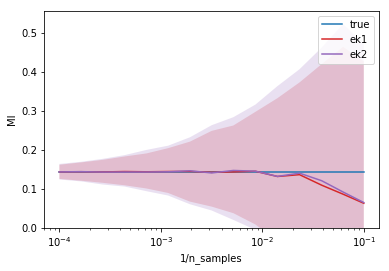

In [27]:
f = plt.figure()
true = np.ones((n.size, n_repeat)) * mi
for x, name in zip([true, mi_k1, mi_k2], ['true', 'ek1', 'ek2']):
    plt.plot(1./n, np.median(x, axis=-1), label=name, c=cs[name])
    if name != 'true':
        plt.fill_between(1./n, np.percentile(x, 2.5, axis=-1), np.percentile(x, 97.5, axis=-1),
                         facecolor=cs[name], alpha=.2)

plt.ylim(0, None)
plt.xscale('log')
plt.ylabel('MI')
plt.xlabel('1/n_samples')
plt.legend()
plt.savefig(os.path.join(os.environ['HOME'], 'Downloads/mi_data_scaling.pdf'))
plt.show()

In [ ]:
mi

# MI implementation

In [ ]:
x = np.random.randn(100, 1)
y = np.random.randn(100, 1)
z = np.concatenate([x, y], axis=1)

In [ ]:
tree = ss.cKDTree(z)
xtree = ss.cKDTree(x)
ytree = ss.cKDTree(y)

In [ ]:
%timeit tree.query(x, 3+1, n_jobs=-1)[0][:, 3]

In [ ]:
%timeit [tree.query(xi, 3+1, n_jobs=-1)[0][3] for xi in x]

In [ ]:
np.allclose(tree.query(x, 3+1)[0][:, 3], np.array([tree.query(xi, 3+1)[0][3] for xi in x]))

# I1 I2 viz

In [10]:
Z = np.array([[0., 0.]])
Z = np.concatenate([Z, np.random.randn(15, 2)], axis=0)
X = Z[:, [0]]
Y = Z[:, [1]]

In [11]:
k = 3
tree = ss.cKDTree(Z)
Xtree = ss.cKDTree(X)
Ytree = ss.cKDTree(Y)

## I1

In [12]:
reload(ksg)
dvec_idx = tree.query(Z, k + 1, p=np.inf)[1][:, k]
dvec = tree.query(Z, k + 1, p=np.inf)[0][:, k]
xidxs = sorted(Xtree.query_ball_point(X[0], dvec[0] - 1e-15, p=float('inf')))[1:]
yidxs = sorted(Ytree.query_ball_point(Y[0], dvec[0] - 1e-15, p=float('inf')))[1:]

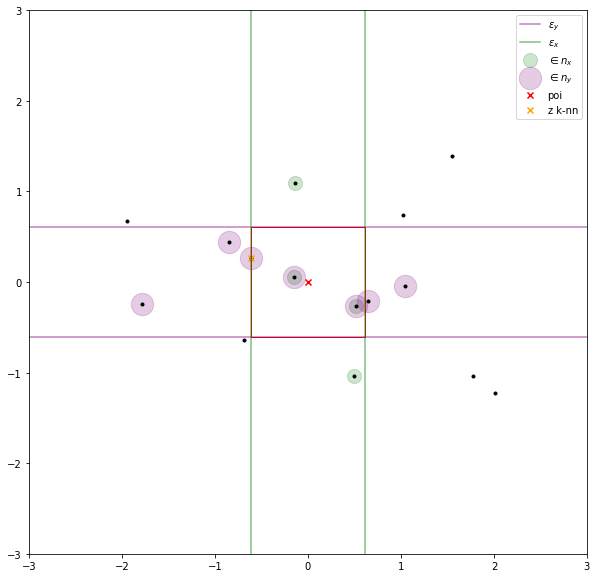

In [13]:
f, ax = plt.subplots(1, figsize=(10, 10))
ax.set_xlim(-3, 3)
ax.set_ylim(-3, 3)
ax.scatter(Z[xidxs,0], Z[xidxs,1], marker='o', color='green', alpha=.2, s=200, label=r'$\in n_x$')
ax.scatter(Z[yidxs,0], Z[yidxs,1], marker='o', color='purple', alpha=.2, s=500, label=r'$\in n_y$')
ax.scatter(Z[1:,0], Z[1:,1], marker='.', color='k')
ax.scatter(Z[0,0], Z[0,1], marker='x', color='red', label='poi')
ax.scatter(Z[dvec_idx[0],0], Z[dvec_idx[0],1], marker='x', color='orange', label='z k-nn')
Z_norm = dvec[0]
r = patches.Rectangle((-Z_norm, -Z_norm), 2*Z_norm, 2*Z_norm, facecolor='None', edgecolor='r')
ax.add_artist(r)
ax.axhline(dvec[0], 0, 1, color='purple', alpha=.5, label=r'$\epsilon_y$')
ax.axhline(-dvec[0], 0, 1, color='purple', alpha=.5)
ax.axvline(dvec[0], 0, 1, color='green', alpha=.5, label=r'$\epsilon_x$')
ax.axvline(-dvec[0], 0, 1, color='green', alpha=.5)
ax.legend()

## I2

In [18]:
didxs = tree.query(Z, k + 1, p=float('inf'))[1][:, 1:]
Xdvec = [np.linalg.norm(xi[np.newaxis]-X[idxs], ord=np.inf, axis=-1).max() for xi, idxs in zip(X, didxs)]
Ydvec = [np.linalg.norm(yi[np.newaxis]-Y[idxs], ord=np.inf, axis=-1).max() for yi, idxs in zip(Y, didxs)]
Xidxs = [np.linalg.norm(xi[np.newaxis]-X[idxs], ord=np.inf, axis=-1).argmax() for xi, idxs in zip(X, didxs)]
Yidxs = [np.linalg.norm(yi[np.newaxis]-Y[idxs], ord=np.inf, axis=-1).argmax() for yi, idxs in zip(Y, didxs)]
xidxs = sorted(Xtree.query_ball_point(X[0], Xdvec[0], p=float('inf')))[1:]
yidxs = sorted(Ytree.query_ball_point(Y[0], Ydvec[0], p=float('inf')))[1:]

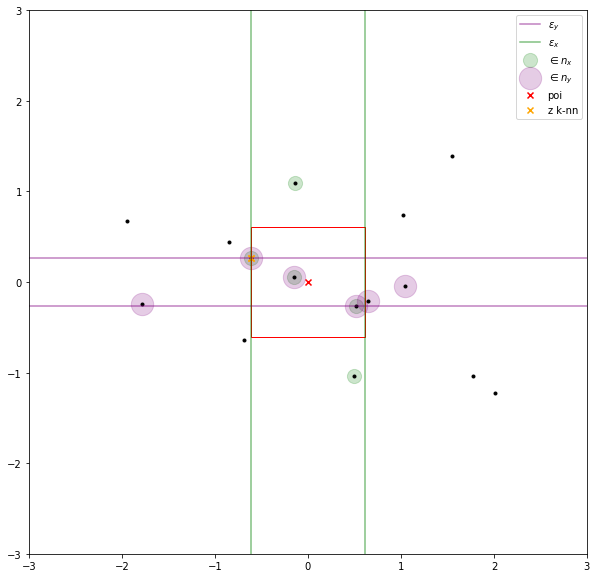

In [121]:
f, ax = plt.subplots(1, figsize=(10, 10))
ax.set_xlim(-3, 3)
ax.set_ylim(-3, 3)
ax.scatter(Z[xidxs,0], Z[xidxs,1], marker='o', color='green', alpha=.2, s=200, label=r'$\in n_x$')
ax.scatter(Z[yidxs,0], Z[yidxs,1], marker='o', color='purple', alpha=.2, s=500, label=r'$\in n_y$')
ax.scatter(Z[1:,0], Z[1:,1], marker='.', color='k')
ax.scatter(Z[0,0], Z[0,1], marker='x', color='red', label='poi')
xidx = didxs[0, Xidxs[0]]
yidx = didxs[0, Xidxs[0]]
ax.scatter(Z[xidx,0], Z[xidx,1], marker='x', color='orange', label='z k-nn')
ax.scatter(Z[yidx,0], Z[yidx,1], marker='x', color='orange')
Z_norm = np.linalg.norm(Z[didxs[0, -1]], ord=np.inf)
r = patches.Rectangle((-Z_norm, -Z_norm), 2*Z_norm, 2*Z_norm, facecolor='None', edgecolor='r')
ax.add_artist(r)
ax.axhline(Ydvec[0], 0, 1, color='purple', alpha=.5, label=r'$\epsilon_y$')
ax.axhline(-Ydvec[0], 0, 1, color='purple', alpha=.5)
ax.axvline(Xdvec[0], 0, 1, color='green', alpha=.5, label=r'$\epsilon_x$')
ax.axvline(-Xdvec[0], 0, 1, color='green', alpha=.5)
ax.legend()

# Mixture Models

In [21]:
from info_measures.numpy import gaussian_mixture

## Entropy

In [117]:
reload(gaussian_mixture)
m = gaussian_mixture.GaussianMixture(7, 5, 1., .1)
mu = m.center[0]
e = np.asscalar(multivariate_normal(mu, np.diag(m.var * np.ones_like(mu))).entropy())

In [118]:
x = []
y = []
y2 = []
for xi in np.logspace(2, 5, 100, dtype=int):
    x.append(xi)
    samples, yi = m.sample_entropy(xi)
    y.append(yi)
    y2.append(ksg.Entropy(samples).entropy())

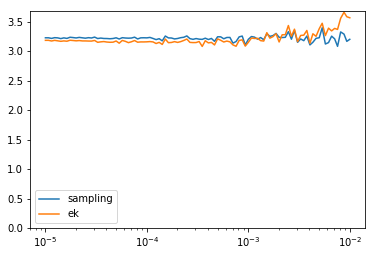

In [120]:
if mu.size == 1:
    plt.plot(1/np.array(x), e *np.ones_like(y), label='true')
plt.plot(1/np.array(x), y, label='sampling')
plt.plot(1/np.array(x), y2, label='ek')
plt.ylim(0, None)
plt.legend()
plt.xscale('log')

ValueError: Unrecognized marker style [ 0.25823942 -0.32636745  1.36682697 ...,  0.94869849 -1.05985026
  0.67330146]

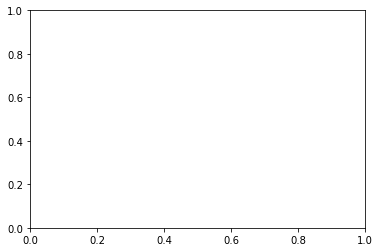

In [116]:
plt.scatter(*samples.T, alpha=.005)

## Mutual Information

In [154]:
reload(gaussian_mixture)
m = gaussian_mixture.GaussianMixture(5, 4, 1., .01)
mu = m.center[0]

In [155]:
var1_dim = 2
x = []
y = []
y2 = []
for xi in np.logspace(2, 4, 50, dtype=int):
    x.append(xi)
    samples, yi = m.sample_mutual_information(xi, var1_dim=var1_dim)
    y.append(yi)
    y2.append(ksg.MutualInformation(samples[:, :var1_dim], samples[:, var1_dim:]).mutual_information())

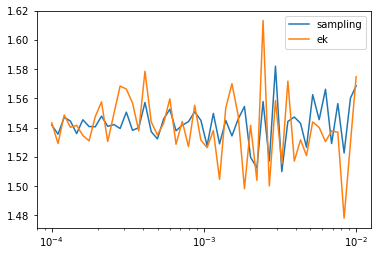

In [156]:
plt.plot(1/np.array(x), y, label='sampling')
plt.plot(1/np.array(x), y2, label='ek')
plt.legend()
plt.xscale('log')